#Music Genre Classifier via CNN



In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtzan-dataset-music-genre-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F568973%2F1032238%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T151532Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da3b08733cbb6e35e3311f2977404918630c460197ce12156b972099f973ab8ca4d9efa72b181851536a8561fe1370775ffe719e8c0d8883839a3e3c77d66314075b6a36150a81fd09d74a0e4aa0d01a65abd0280035b8cf46ea1f598efc29e009689d528b1cd26905f394feb24f3962f98942b341b6f20156df7210cb0c62daf4b66ce734b278bc795a8fea8be1b99dc1edbc88ed120d812d3b5873616d7da430fb67cc135eea773b09360bae20124e589f1264bf504330dcbc790228926aeae5183fe2ee83de860509a58d9a0f9776107b9dfe6992602a1b963c5b889227f772eaf5f04be02a7dabc21bcbcc816ef237da1562d1910600ebb7044d323b98e4b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1301492495 bytes downloaded
Downloaded and uncompressed: gtzan-dataset-music-genre-classification
Data source import complete.


#The goal of this project is to categorize 30-second audio clips into different genres using TensorFlow and Librosa. To classify these .wav audio samples by genre, we will preprocess them by computing their Mel-Frequency Cepstral Coefficients (MFCCs). MFCCs provide a representation of how the energy varies over time for different perceived frequency bands. In this case, we will use 13 frequency bands. For better organization and readability, we will store the MFCCs and their corresponding genre labels in a separate JSON file, creating a dictionary-like data structure.

In [2]:
!pip install -y ffmpeg


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [3]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

In [4]:
# Dataset location
SOURCE_PATH = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/'

# Path to labels and processed data file, json format.
JSON_PATH = '/kaggle/working/data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples and pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# The dataset contains 999 files. Lets make it bigger.
# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [5]:
def preprocess_data(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Write the dictionary in a json file.
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [6]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [7]:
def prepare_datasets(inputs, targets, split_size):

    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)

    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]

    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [8]:
def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [9]:
def make_prediction(model, X, y, idx):

    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }

    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])

    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))


In [10]:
def plot_performance(hist):

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [11]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

In [12]:
inputs, targets = load_data(json_path=JSON_PATH)

In [13]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

In [14]:
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = design_model(input_shape)

In [15]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 62, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 2, 32)         0         
 g2D)                                                            
                                                        

In [17]:
#Training the model.
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xval, yval),
                    epochs=30,
                    batch_size=32
                    )

Epoch 1/30
200/200 [==============================] - 16s 74ms/step - loss: 1.5911 - acc: 0.4402 - val_loss: 1.3006 - val_acc: 0.5390
Epoch 2/30
200/200 [==============================] - 13s 65ms/step - loss: 1.1560 - acc: 0.5905 - val_loss: 1.1061 - val_acc: 0.6106
Epoch 3/30
200/200 [==============================] - 13s 63ms/step - loss: 0.9679 - acc: 0.6460 - val_loss: 0.9702 - val_acc: 0.6597
Epoch 4/30
200/200 [==============================] - 13s 66ms/step - loss: 0.8694 - acc: 0.6898 - val_loss: 1.0593 - val_acc: 0.6431
Epoch 5/30
200/200 [==============================] - 14s 72ms/step - loss: 0.7736 - acc: 0.7278 - val_loss: 0.8465 - val_acc: 0.7077
Epoch 6/30
200/200 [==============================] - 13s 63ms/step - loss: 0.7180 - acc: 0.7444 - val_loss: 0.7850 - val_acc: 0.7337
Epoch 7/30
200/200 [==============================] - 14s 68ms/step - loss: 0.6621 - acc: 0.7640 - val_loss: 0.9509 - val_acc: 0.6847
Epoch 8/30
200/200 [==============================] - 12s 61ms

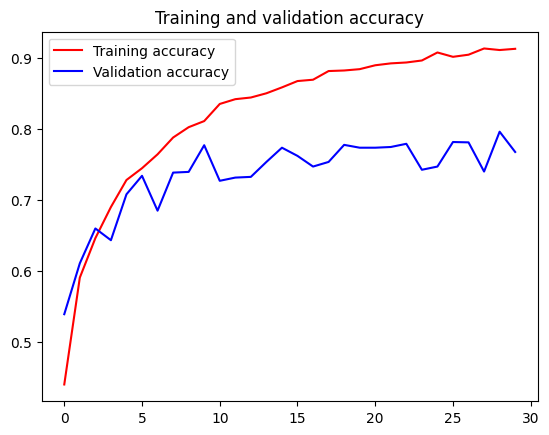

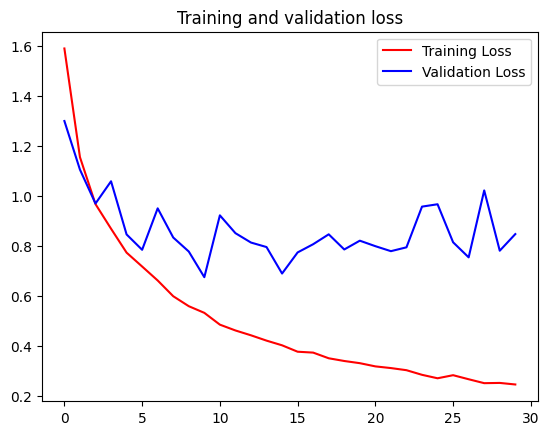

In [18]:
plot_performance(history)

In [19]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["acc"], label="train accuracy")
    axs[0].plot(hist.history["val_acc"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [21]:
make_prediction(model, Xtest, ytest, 24)

50/50 [==============================] - 1s 13ms/step

---Now testing the model for one audio file---
The model predicts: hiphop, and ground truth is: classical.



In [22]:
import pickle

# Save the model to a file
with open('CNN.pkl', 'wb') as file:
    pickle.dump(model, file)

In [23]:
# Load the model from the file
with open('CNN.pkl', 'rb') as file_new:
    model_new = pickle.load(file_new)

In [24]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 62, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 2, 32)         0         
 g2D)                                                            
                                                        

In [25]:
# Expected dimensions for the input
expected_height = 123
expected_width = 11

# Function to preprocess audio file
def preprocess_audio(file_path, sr=22050, duration=30, height=expected_height, width=expected_width):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)

    # Ensure audio is the expected duration
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, max(0, sr * duration - len(audio))), 'constant')

    # Extract features (e.g., Mel spectrogram)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=height, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Reshape for resizing
    mel_spec_db = mel_spec_db[..., np.newaxis]  # Add channel dimension
    mel_spec_db = tf.image.resize(mel_spec_db, (height, width)).numpy()

    # Reshape for the model input
    mel_spec_db = mel_spec_db[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
    return mel_spec_db

In [29]:
new_file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00002.wav'
audio_data = preprocess_audio(new_file)

Training accuracy: 0.9124041795730591
Test accuracy: 0.7672672867774963


<Figure size 2000x1500 with 0 Axes>

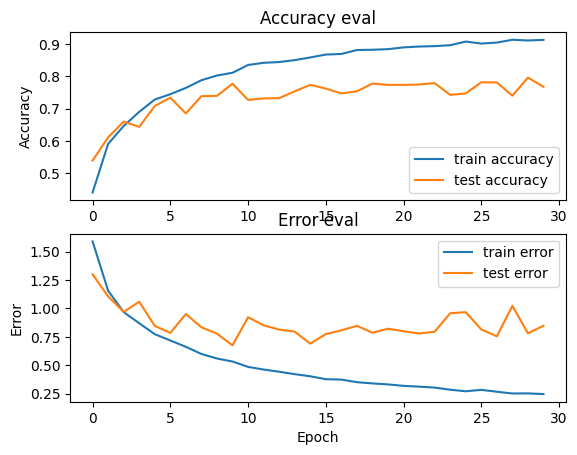

In [20]:
# Retrieve training and validation accuracy
train_accuracy = history.history['acc'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_acc'][-1]  # Last epoch validation accuracy

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)
plot_history(history)